# Process the ATL06SR Data - get it ready for figures and analysis  
Use conda environment ~~datum_reproj3~~  analysis_2022
________________________

Originally written by David Shean - notebook named GM_analysis_20211122.ipynb 
November 22, 2021  

Much of this code was adapted by Hannah Besso from code written by David Shean in 2021  
(his original notebook named GM_analysis_20211122.ipynbnotebook named GM_analysis_20211122.ipynb)
______________

### Steps In This Notebook:    
* Label ATL06SR data as snow-on (snow_presence = 1) or snow-off (snow_presence = 0) based on snow presence at SNOTEL sites.   

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
#from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.time import Time
import datetime
import rioxarray as rxr
from rasterio.plot import show
import rasterio as rio
from rasterio import features
import hvplot.pandas
import pickle
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts
#from imview.lib import pltlib

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '16'

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def nmad(df):
    return scipy.stats.median_abs_deviation(df, nan_policy='omit', scale='normal')

def p16(df):
    return np.nanpercentile(df, 16)

def p84(df):
    return np.nanpercentile(df, 84)

def spread(df):
    return p84(df) - p16(df)

In [6]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [7]:
#map_tiles = EsriImagery()
#map_tiles = StamenTerrain()
map_tiles = gvts.StamenTerrain

In [8]:
kw = {'width':500, 'height':400, 'hover':False, 'data_aspect':1, 'alpha':1.0}
kw['colorbar'] = True
kw['cmap'] = 'inferno'
#kw['s'] = 1
#kw['aggregator'] = 'mean'
#kw['rasterize'] = False
#Using datashade drops colorbar
kw['datashade'] = True
#kw['dynamic'] = True
#kw['backend'] = 'matplotlib'

# Load SlideRule

In [9]:
atl06sr = pickle.load(open('../../data/atl06/methow_all_sr-atl06-10182022.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_68144/1215892880.py:1: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  atl06sr = pickle.load(open('../../data/atl06/methow_all_sr-atl06-10182022.pkl', 'rb'))


In [11]:
atl06sr.head(2)

,pflags,h_mean,dh_fit_dy,spot,w_surface_window_final,h_sigma,distance,segment_id,dh_fit_dx,rgt,cycle,delta_time,gt,n_fit_photons,rms_misfit,geometry,acqdate
time,,,,,,,,,,,,,,,,,
2018-11-09 22:09:43.662511060,0,774.110259,0.0,5,9.386548,0.079705,5.382001e+06,268398,0.367318,646,1,2.703658e+07,20,41,0.506044,POINT (-120.00053 48.33917),2018-11-09
2018-11-09 22:09:43.789049908,0,919.941824,0.0,5,3.000000,0.050617,5.382903e+06,268443,0.028568,646,1,2.703658e+07,20,42,0.305572,POINT (-120.00167 48.34723),2018-11-09


In [12]:
# Old way of reading in the data, before I got pickle to work.

# atl06sr_fn = '../../data/atl06/tuolumne_all_sr-atl06-07022022.geojson'
# atl06sr_gdf_ll = gpd.read_file(atl06sr_fn)
# atl06sr_gdf_ll.time = pd.DatetimeIndex(atl06sr_gdf_ll.time)
# atl06sr_gdf_ll = atl06sr_gdf_ll.set_index(['time'])
# atl06sr_gdf_ll.sort_index(inplace=True)
# atl06sr_gdf_ll['acqdate'] = atl06sr_gdf_ll.index.date
# atl06sr_col = 'h_mean'
# atl06sr_title = 'ICESat-2 ATL06-SR 40m (ground)'
# atl06sr_gdf_ll.shape

In [10]:
atl06sr_gdf = atl06sr.set_crs('epsg:7912', allow_override=True)

In [11]:
add_dowy(atl06sr_gdf)

Adding Day of Water Year (DOWY)


In [20]:
atl06sr_gdf.head(2)

,pflags,h_mean,dh_fit_dy,spot,w_surface_window_final,h_sigma,distance,segment_id,dh_fit_dx,rgt,cycle,delta_time,gt,n_fit_photons,rms_misfit,geometry,doy,decyear,dowy
time,,,,,,,,,,,,,,,,,,,
2018-11-09 22:09:43.662511060,0,774.110259,0.0,5,9.386548,0.079705,5.382001e+06,268398,0.367318,646,1,2.703658e+07,20,41,0.506044,POINT (-120.00053 48.33917),313,2018.857324,40
2018-11-09 22:09:43.789049908,0,919.941824,0.0,5,3.000000,0.050617,5.382903e+06,268443,0.028568,646,1,2.703658e+07,20,42,0.305572,POINT (-120.00167 48.34723),313,2018.857324,40


## Export a snow-off point file for use with pc_align

In [18]:
# Did this to create a csv file to use with pc_align
#atl06sr_gdf_ll['x'] = atl06sr_gdf_ll.geometry.x.values
#atl06sr_gdf_ll['y'] = atl06sr_gdf_ll.geometry.y.values
#add_dowy(atl06sr_gdf_ll)
#atl06sr_gdf_ll.to_csv(r'ATL06-SR_Methow_20220201183616_004.csv', index=None)

## Load a polygon of the study area

In [12]:
outline_gdf = pickle.load(open('../../data/site_outlines/methow_outline_4326.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_68144/896896808.py:1: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  outline_gdf = pickle.load(open('../../data/site_outlines/methow_outline_4326.pkl', 'rb'))


### Find the Area of the Study Site

In [17]:
area = outline_gdf['geometry'].area/ 10**6
area

3    1792.769054
dtype: float64

In [13]:
# This is UTM Zone 11N
outline_snowoff_extent = outline_gdf.total_bounds
outline_snowoff_extent

array([-120.59027419,   48.2399849 , -119.87668762,   48.80903198])

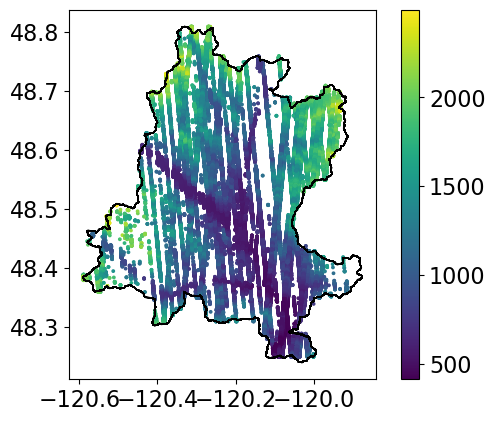

In [17]:
fig, ax = plt.subplots()

atl06sr_gdf.plot(column='h_mean', ax=ax, markersize=3, legend=True)
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k');

### Load snow data, cleaned in AUX_data_clean.ipynb

In [14]:
snwd = pickle.load(open('../data/snotel/snotel_snwd_35.pkl', 'rb'))

In [25]:
snwd.head(2)

,Muckamuck,Salmon Meadows,doy,decyear,dowy,acqdate
2018-10-03,0.0,0.0,276,2018.753425,3,2018-10-03
2018-10-04,0.0,0.0,277,2018.756164,4,2018-10-04


### Plot the snow depth

Text(0, 0.5, 'Snow Depth m')

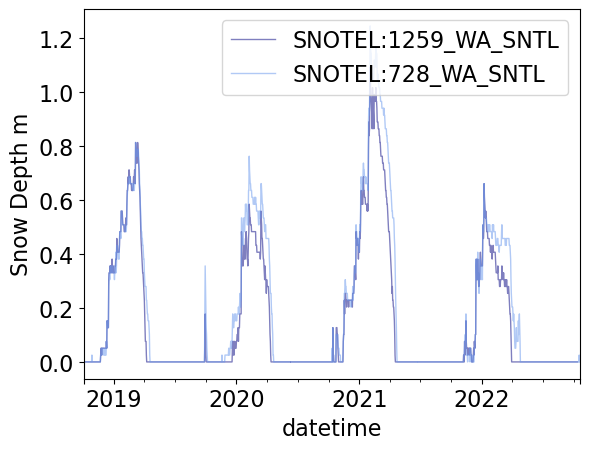

In [31]:
fig, ax = plt.subplots()
snwd[['SNOTEL:1259_WA_SNTL','SNOTEL:728_WA_SNTL']].plot(alpha=0.5, color=['navy', 'cornflowerblue'], lw=1, ax=ax)
#ax.axhline(y = 0, c = 'k')
plt.ylabel('Snow Depth m')

### Determine average snow-free dates

In [26]:
snwd

,SNOTEL:1259_WA_SNTL,SNOTEL:728_WA_SNTL
datetime,,
2018-10-03 00:00:00+00:00,0.0,0.0000
2018-10-04 00:00:00+00:00,0.0,0.0000
2018-10-05 00:00:00+00:00,0.0,0.0000
2018-10-06 00:00:00+00:00,0.0,0.0000
2018-10-07 00:00:00+00:00,0.0,0.0000
...,...,...
2022-10-14 00:00:00+00:00,NaN,0.0000
2022-10-15 00:00:00+00:00,NaN,0.0000
2022-10-16 00:00:00+00:00,NaN,0.0000


In [15]:
idx_st = (snwd[['Muckamuck', 'Salmon Meadows']] < 0.1).all(axis=1)

(90.0, 360.0)

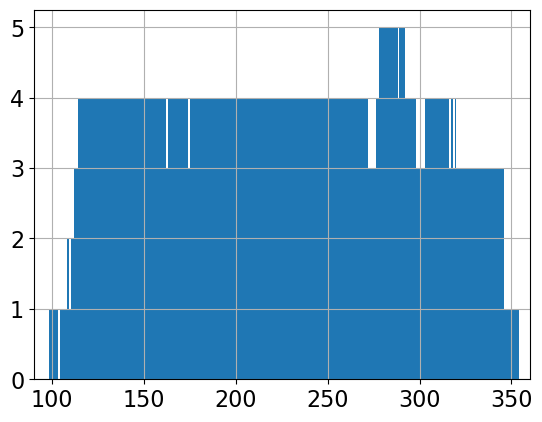

In [19]:
fig, ax = plt.subplots()
snwd[idx_st]['doy'].hist(bins=365, range=(0,365), ax=ax)
ax.set_xlim(90, 360)

I'm suspicious of this - too many snow free days, the snotel sites are pretty low compared to the study site

In [16]:
snowfree_doy_range = (100,350)

In [17]:
snowoff_days_percent = (snowfree_doy_range[1] - snowfree_doy_range[0]) / 360 * 100
snowoff_days_percent

69.44444444444444

## Label data as snow off or snow on

In [18]:
idx = (atl06sr_gdf['doy'] >= snowfree_doy_range[0]) & (atl06sr_gdf['doy'] <= snowfree_doy_range[1])

In [31]:
idx

time
2018-11-09 22:09:43.662511060    True
2018-11-09 22:09:43.789049908    True
2018-11-09 22:09:43.794872008    True
2018-11-09 22:09:43.797684372    True
2018-11-09 22:09:43.800494952    True
                                 ... 
2022-06-06 07:54:57.627617920    True
2022-06-06 07:54:57.630443216    True
2022-06-06 07:54:57.902096240    True
2022-06-06 07:54:57.904934768    True
2022-06-06 07:54:57.907769088    True
Name: doy, Length: 148886, dtype: bool

In [19]:
atl06sr_gdf['snow_presence'] = ""
atl06sr_gdf.loc[idx, 'snow_presence'] = 0
atl06sr_gdf.loc[~idx, 'snow_presence'] = 1

In [47]:
atl06sr_gdf.head(2)

,pflags,h_mean,dh_fit_dy,spot,w_surface_window_final,h_sigma,distance,segment_id,dh_fit_dx,rgt,cycle,delta_time,gt,n_fit_photons,rms_misfit,geometry,acqdate,doy,decyear,dowy,snow_presence
time,,,,,,,,,,,,,,,,,,,,,
2018-11-09 22:09:43.662511060,0,774.110259,0.0,5,9.386548,0.079705,5.382001e+06,268398,0.367318,646,1,2.703658e+07,20,41,0.506044,POINT (722265.057 5358346.501),2018-11-09,313,2018.857324,40,0
2018-11-09 22:09:43.789049908,0,919.941824,0.0,5,3.000000,0.050617,5.382903e+06,268443,0.028568,646,1,2.703658e+07,20,42,0.305572,POINT (722145.580 5359238.959),2018-11-09,313,2018.857324,40,0


Text(0.5, 1.0, 'Snow On')

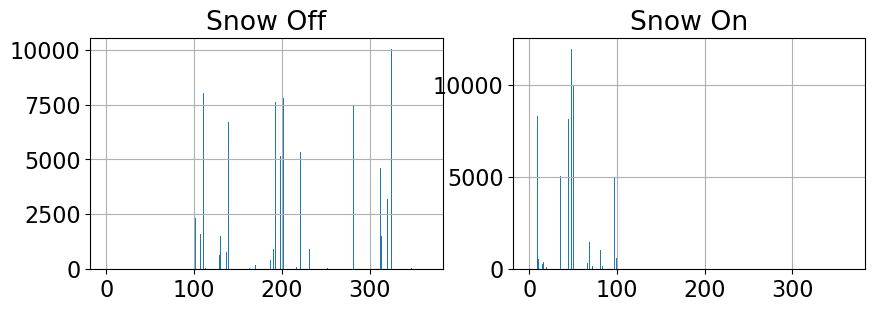

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
atl06sr_gdf['doy'][atl06sr_gdf['snow_presence'] == 0].hist(bins=365, range=(0,365), ax=ax[0])
atl06sr_gdf['doy'][atl06sr_gdf['snow_presence'] == 1].hist(bins=365, range=(0,365), ax=ax[1])
ax[0].set_title('Snow Off')
ax[1].set_title('Snow On')

In [21]:
# Save progress: save ATL06SR file prior to DEM differencing (done on Oct 18, 2022 to save my progress in this notebook temporarily)

atl06sr_temp_fn = '../../data/atl06/methow_all_sr-atl06-10172022_processed_wo-dems_7912.pkl'

with open(atl06sr_temp_fn, 'wb') as f:
    pickle.dump(atl06sr_gdf, f)

In [51]:
atl06sr_gdf = pickle.load(open(atl06sr_temp_fn, 'rb'))

In [52]:
atl06sr_gdf.head()

,pflags,h_mean,dh_fit_dy,spot,w_surface_window_final,h_sigma,distance,segment_id,dh_fit_dx,rgt,cycle,delta_time,gt,n_fit_photons,rms_misfit,geometry,acqdate,doy,decyear,dowy,snow_presence
time,,,,,,,,,,,,,,,,,,,,,
2018-11-09 22:09:43.662511060,0,774.110259,0.0,5,9.386548,0.079705,5.382001e+06,268398,0.367318,646,1,2.703658e+07,20,41,0.506044,POINT (722265.057 5358346.501),2018-11-09,313,2018.857324,40,0
2018-11-09 22:09:43.789049908,0,919.941824,0.0,5,3.000000,0.050617,5.382903e+06,268443,0.028568,646,1,2.703658e+07,20,42,0.305572,POINT (722145.580 5359238.959),2018-11-09,313,2018.857324,40,0
2018-11-09 22:09:43.794872008,0,918.460968,0.0,5,3.029108,0.046853,5.382943e+06,268445,-0.116342,646,1,2.703658e+07,20,31,0.240537,POINT (722140.182 5359280.079),2018-11-09,313,2018.857324,40,0
2018-11-09 22:09:43.797684372,0,916.399163,0.0,5,3.000000,0.059160,5.382963e+06,268446,-0.091024,646,1,2.703658e+07,20,39,0.325805,POINT (722137.582 5359299.951),2018-11-09,313,2018.857324,40,0
2018-11-09 22:09:43.800494952,0,915.721672,0.0,5,3.000000,0.038990,5.382983e+06,268447,-0.027886,646,1,2.703658e+07,20,40,0.245902,POINT (722134.962 5359319.820),2018-11-09,313,2018.857324,40,0
